[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Compute agroclimatic indicators
This notebook shows how to use the climate projection data, downloaded and debiased in previous notebooks, to compute agroclimatic indicators.

## Installing and importing necessary libraries

In order to run this notebook, the python environment has to be prepared by installing a number of additional libraries:
* `icclim` - Generating climate indices
* `scitools-iris` - Loading and regridding data (has to be installed via conda)
* `cartopy` - Visualising maps
* `xarray (v0.21.1)` - Specific xarray version for compatibility with icclim

In [2]:
! conda install -c conda-forge iris==3.11.0 -y

Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\girza001\.conda\envs\agroclim

  added / updated specs:
    - iris


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cartopy-0.24.0             |  py313hf91d08e_0         1.5 MB  conda-forge
    cf-units-3.3.0             |  py313h8e081ca_0         526 KB  conda-forge
    cftime-1.6.4               |  py313h8e081ca_1         175 KB  conda-forge
    contourpy-1.3.1            |  py313h1ec8472_0         212 KB  conda-forge
    curl-8.9.1                 |       h3f729d1_0         176 KB
    fonttools-4.56.0           |  py313hb4c8b1a_0         2.3 MB  conda-forge
    freetype-2.12.1            |       ha860e81_0         490 KB
    hdf4-4.2.15                |       h0e5069d_3         1.1 MB  conda-forge
    hdf5-1.10.6                |nompi_he0

In [1]:
# Install other required libraries via pip
! pip install xarray==2023.10.1 icclim==6.5.0 numpy==1.26.4 xclim==0.47.0

  Using cached netCDF4-1.7.2-cp313-cp313-win_amd64.whl.metadata (1.8 kB)
Using cached netCDF4-1.7.2-cp313-cp313-win_amd64.whl (7.0 MB)


In [1]:
from pathlib import Path   # Working with system paths and directories

import cartopy.crs as ccrs
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import xarray as xr
import iris
import icclim

*Select the directory where climate data is stored (consistent with the `PARENT_PATH` of the `00 - Download and Preprocess Data.ipynb` notebook)*

In [2]:
PARENT_PATH = "./Data/agroclim_data" 

In [3]:
# Define the directory structure, starting at the parent path
parent_path = Path(PARENT_PATH)

combined_hist_model_path = parent_path / "combined_historical_model.nc"
combined_hist_obs_path = parent_path / "combined_historical_obs.nc"
combined_future_model_path = parent_path / "combined_future_model.nc"
combined_future_debiased_path = parent_path / "combined_future_debiased.nc"

In [4]:
# Helper function to visualise the results of a specific indicator
def visualise_index(index_ds, index_variable, figure_title, mask_values=None, cmin = None, cmax = None):
    index_data = index_ds[index_variable]
    if index_data.shape[0] > 1:
        index_data_agg = index_data[[-1]]
        index_data_agg[0].values = index_data.mean(dim='time').values
        index_data = index_data_agg
    if mask_values:
        for mask_value in mask_values:
            index_data = index_data.where(index_data != mask_value)
        
    # This is the map projection we want to plot *onto*
    map_proj = ccrs.Mercator()
    
    p = index_data.plot(
        transform=ccrs.PlateCarree(),  # the data's projection
        col="time",
        col_wrap=1,  # multiplot settings
        aspect=index_ds.dims["lon"] / index_ds.dims["lat"],  # for a sensible figsize
        subplot_kws={"projection": map_proj},
    )  # the plot's projection

    # Set color limits of quadmesh
    for i in p.axs.flat: 
        for j in i.get_children(): 
            if isinstance(j, mpl.collections.QuadMesh):
                j.set_clim((cmin, cmax))
         
    # We have to set the map's options on all axes
    for ax in p.axs.flat:
        ax.coastlines()
        ax.set_extent([-12,2, 45, 35])
        ax.set_title(figure_title)
    plt.show()

Agroclimatic indicator definitions can be found here: https://confluence.ecmwf.int/pages/viewpage.action?pageId=278550975

## CDD
**Description:** Maximum number of consecutive dry days
(Drought spell)

**Application:** Drought monitoring, drought damage indicator

2025-03-27 08:51:37,461 --- icclim 6.5.0
2025-03-27 08:51:37,461 --- BEGIN EXECUTION
2025-03-27 08:51:37,463 Processing: 0%
2025-03-27 08:51:37,630 Processing: 100%
2025-03-27 08:51:37,630 --- icclim 6.5.0
2025-03-27 08:51:37,630 --- CPU SECS = 3.188     
2025-03-27 08:51:37,630 --- END EXECUTION


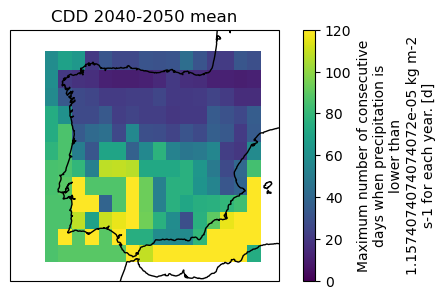

In [5]:
cdd = icclim.index(
    index_name="CDD",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="pr_debiased",
)

cdd_min = float(cdd['CDD'].min().values)
cdd_max = float(cdd['CDD'].max().values)

visualise_index(cdd, 'CDD', "CDD 2040-2050 mean", mask_values = [366], cmin = 0, cmax = 120)

## CFD
**Description:** Maximum number of consecutive frost days
(Cold spell)

**Application:** General frost damage indicator

2025-03-27 08:51:45,113 --- icclim 6.5.0
2025-03-27 08:51:45,113 --- BEGIN EXECUTION
2025-03-27 08:51:45,113 Processing: 0%
2025-03-27 08:51:45,161 Processing: 100%
2025-03-27 08:51:45,161 --- icclim 6.5.0
2025-03-27 08:51:45,161 --- CPU SECS = 4.406     
2025-03-27 08:51:45,161 --- END EXECUTION


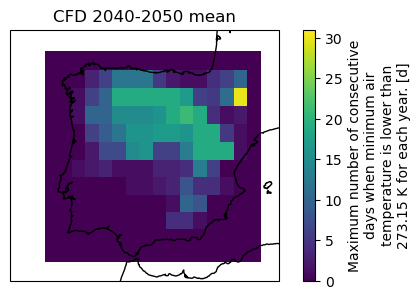

In [6]:
cfd = icclim.index(
    index_name="CFD",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmin_debiased",
)

cfd_min = float(cfd['CFD'].min().values)
cfd_max = float(cfd['CFD'].max().values)

visualise_index(cfd, 'CFD', "CFD 2040-2050 mean", cmin = cfd_min, cmax = cfd_max)

## CSDI
**Description:** Cold-spell duration index

**Application:** Provides information on reduced
blossom formation or reduced growth

2025-03-26 17:31:08,545 --- icclim 7.0.0
2025-03-26 17:31:08,545 --- BEGIN EXECUTION
2025-03-26 17:31:08,545 Processing: 0%
2025-03-26 17:31:08,704 Processing: 100%
2025-03-26 17:31:08,704 --- icclim 7.0.0
2025-03-26 17:31:08,704 --- CPU SECS = 36.078    
2025-03-26 17:31:08,704 --- END EXECUTION


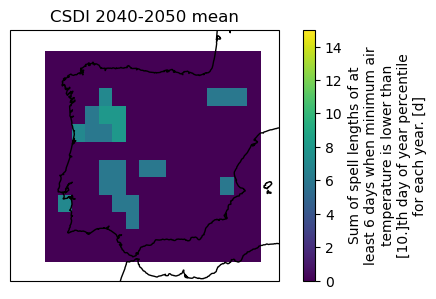

In [50]:
csdi = icclim.index(
    index_name="CSDI",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmin_debiased",
)

csdi_min = float(csdi['CSDI'].min().values)
csdi_max = float(csdi['CSDI'].max().values)

visualise_index(csdi, 'CSDI', "CSDI 2040-2050 mean", cmin = 0, cmax = 15)

## WSDI
**Description:** Warm-spell duration index

**Application:** Provide an indication concerning the occurrence of heat stress on reduced blossom formation or reduced growth.

2025-03-26 17:31:26,080 --- icclim 7.0.0
2025-03-26 17:31:26,082 --- BEGIN EXECUTION
2025-03-26 17:31:26,082 Processing: 0%
2025-03-26 17:31:26,257 Processing: 100%
2025-03-26 17:31:26,259 --- icclim 7.0.0
2025-03-26 17:31:26,259 --- CPU SECS = 36.578    
2025-03-26 17:31:26,259 --- END EXECUTION


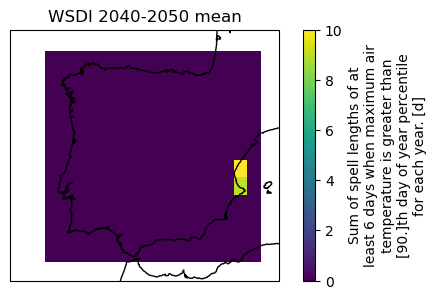

In [51]:
wsdi = icclim.index(
    index_name="WSDI",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmax_debiased",
)

wsdi_min = float(wsdi['WSDI'].min().values)
wsdi_max = float(wsdi['WSDI'].max().values)

visualise_index(wsdi, 'WSDI', "WSDI 2040-2050 mean", cmin = 0, cmax = 10)

## CSU
**Description:** Maximum number of consecutive summer days
(Hot spell)

**Application:** Provides information on
heat stress or on optimal growth for C4
crops (e.g. maize)

2025-03-26 17:33:04,113 --- icclim 7.0.0
2025-03-26 17:33:04,113 --- BEGIN EXECUTION
2025-03-26 17:33:04,113 Processing: 0%
2025-03-26 17:33:04,167 Processing: 100%
2025-03-26 17:33:04,167 --- icclim 7.0.0
2025-03-26 17:33:04,167 --- CPU SECS = 41.984    
2025-03-26 17:33:04,167 --- END EXECUTION


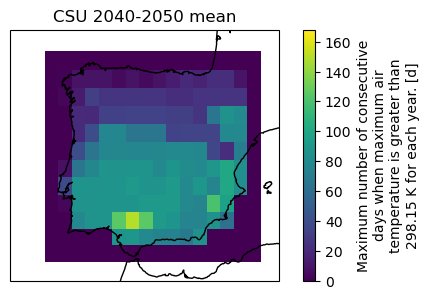

In [54]:
csu = icclim.index(
    index_name="CSU",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmax_debiased",
)

csu_min = float(csu['CSU'].min().values)
csu_max = float(csu['CSU'].max().values)

visualise_index(csu, 'CSU', "CSU 2040-2050 mean", cmin = csu_min, cmax = csu_max)


## CWD
**Description:** Maximum number of consecutive
wet days (Wet spell)

**Application:** Provides information on drought/oxygen
stress/ crop growth (i.e. less radiation interception during rainy days)

2025-03-26 17:33:13,316 --- icclim 7.0.0
2025-03-26 17:33:13,318 --- BEGIN EXECUTION
2025-03-26 17:33:13,318 Processing: 0%
2025-03-26 17:33:13,355 Processing: 100%
2025-03-26 17:33:13,355 --- icclim 7.0.0
2025-03-26 17:33:13,355 --- CPU SECS = 42.641    
2025-03-26 17:33:13,355 --- END EXECUTION


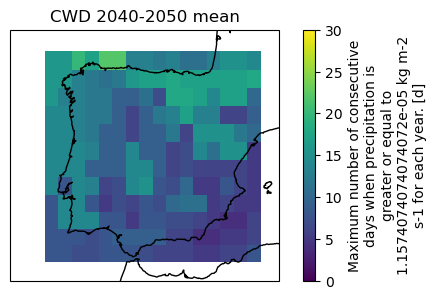

In [56]:
cwd = icclim.index(
    index_name="CWD",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="pr_debiased",
)

cwd_min = float(cwd['CWD'].min().values)
cwd_max = float(cwd['CWD'].max().values)

visualise_index(cwd, 'CWD', "CWD 2040-2050 mean", mask_values=[366], cmin = 0, cmax = 30)

## WW
**Description:** Warm and wet days

**Application:** Provide an indication of occurrence of various pests insects and especially fungi Provides an indication concerning the crop development, especially leave formation.

2025-03-26 17:33:22,075 --- icclim 7.0.0
2025-03-26 17:33:22,075 --- BEGIN EXECUTION
2025-03-26 17:33:22,075 Processing: 0%
2025-03-26 17:33:22,230 Processing: 100%
2025-03-26 17:33:22,230 --- icclim 7.0.0
2025-03-26 17:33:22,230 --- CPU SECS = 43.047    
2025-03-26 17:33:22,230 --- END EXECUTION


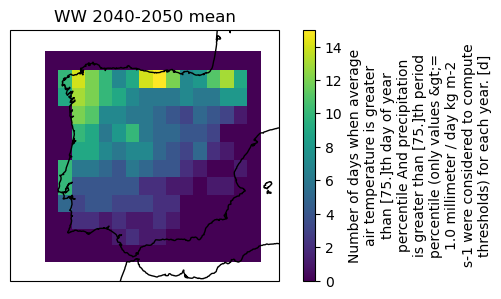

In [57]:
ww = icclim.index(
    index_name="WW",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name=["tas_debiased", "pr_debiased"]
)

ww_min = float(ww['WW'].min().values)
ww_max = float(ww['WW'].max().values)

visualise_index(ww, 'WW', "WW 2040-2050 mean", cmin = 0, cmax = 15)

## DTR
**Description:** Mean of diurnal temperature range

**Application:** Provides information on climate variability and change. Also serves as the proxy for information on the clarity
(transmittance) of the atmosphere

2025-03-26 17:33:28,090 --- icclim 7.0.0
2025-03-26 17:33:28,090 --- BEGIN EXECUTION
2025-03-26 17:33:28,090 Processing: 0%
2025-03-26 17:33:28,114 Processing: 100%
2025-03-26 17:33:28,114 --- icclim 7.0.0
2025-03-26 17:33:28,114 --- CPU SECS = 43.344    
2025-03-26 17:33:28,114 --- END EXECUTION


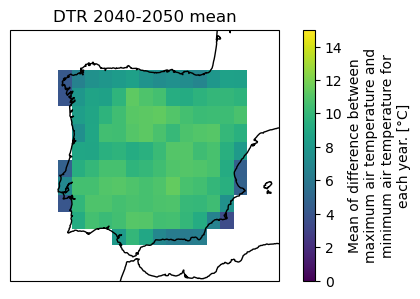

In [58]:
dtr = icclim.index(
    index_name="DTR",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name=["tasmax_debiased", "tasmin_debiased"]
)

dtr_min = float(dtr['DTR'].min().values)
dtr_max = float(dtr['DTR'].max().values)

visualise_index(dtr, 'DTR', "DTR 2040-2050 mean", cmin = 0, cmax = 15)

## BEDD
**Description:** Biologically Effective Degree Days

**Application:** Determines crop development stages/rates. Crop development will decelerate/accelerate below and above
certain threshold temperatures.

2025-03-27 08:53:06,393 --- icclim 6.5.0
2025-03-27 08:53:06,393 --- BEGIN EXECUTION
2025-03-27 08:53:06,393 Processing: 0%
2025-03-27 08:53:06,463 Processing: 100%
2025-03-27 08:53:06,463 --- icclim 6.5.0
2025-03-27 08:53:06,463 --- CPU SECS = 4.766     
2025-03-27 08:53:06,463 --- END EXECUTION


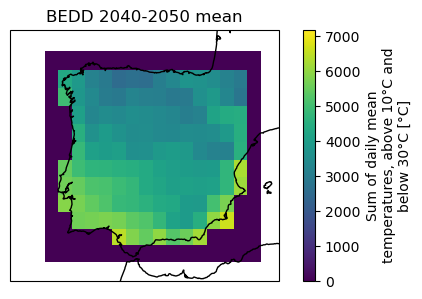

In [7]:
# import xclim for converting °K to °C
from xclim.core import units

# Minimum temprature in °C
T_min = 10

# Maximum temperature in °C
T_max = 30

# Import the temperature dataset and convert units to °C
tas_ds = xr.open_dataset(
    f"{combined_future_debiased_path.resolve()}"
)
tas_ds['tas_debiased'] = units.convert_units_to(tas_ds['tas_debiased'], "deg_C")

bedd = icclim.sum(
    tas_ds,
    var_name="tas_debiased",
    threshold=f"> {T_min} deg_C AND < {T_max} deg_C",
)
bedd['sum'].attrs['long_name'] = f"Sum of daily mean temperatures, above {T_min}°C and below {T_max}°C"

bedd_min = float(bedd['sum'].min().values)
bedd_max = float(bedd['sum'].max().values)

visualise_index(bedd, 'sum', "BEDD 2040-2050 mean", cmin = bedd_min, cmax = bedd_max)


## GSL
**Description:** Growing Season Length

**Application:** Provides an indication whether a crop or a combination of crops can be sown and subsequently reach maturity within a
certain time frame

2025-03-26 17:35:57,227 --- icclim 7.0.0
2025-03-26 17:35:57,227 --- BEGIN EXECUTION
2025-03-26 17:35:57,233 Processing: 0%
2025-03-26 17:35:57,894 Processing: 100%
2025-03-26 17:35:57,894 --- icclim 7.0.0
2025-03-26 17:35:57,894 --- CPU SECS = 44.500    
2025-03-26 17:35:57,894 --- END EXECUTION


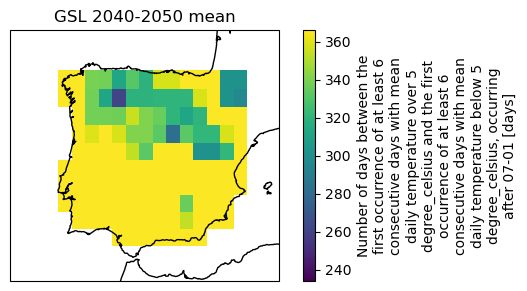

In [63]:
gsl = icclim.index(
    index_name="GSL",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tas_debiased",
)

gsl_min = float(gsl['GSL'].min().values)
gsl_max = float(gsl['GSL'].max().values)

visualise_index(gsl, 'GSL', "GSL 2040-2050 mean", cmin = gsl_min, cmax = gsl_max)

## FD
**Description:** Frost Days

**Application:** Provides information on frost damage

2025-03-26 17:36:05,417 --- icclim 7.0.0
2025-03-26 17:36:05,419 --- BEGIN EXECUTION
2025-03-26 17:36:05,420 Processing: 0%
2025-03-26 17:36:05,462 Processing: 100%
2025-03-26 17:36:05,462 --- icclim 7.0.0
2025-03-26 17:36:05,464 --- CPU SECS = 45.359    
2025-03-26 17:36:05,464 --- END EXECUTION


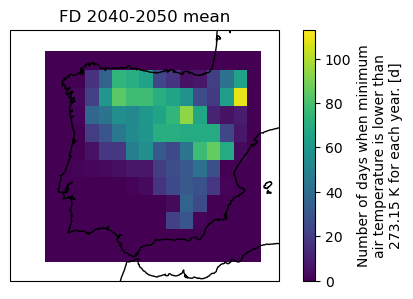

In [64]:
fd = icclim.index(
    index_name="FD",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmin_debiased",
)

fd_min = float(fd['FD'].min().values)
fd_max = float(fd['FD'].max().values)

visualise_index(fd, 'FD', "FD 2040-2050 mean", cmin = fd_min, cmax = fd_max)

## ID
**Description:** Ice Days

**Application:** Provides information on frost damage

2025-03-26 17:36:11,809 --- icclim 7.0.0
2025-03-26 17:36:11,809 --- BEGIN EXECUTION
2025-03-26 17:36:11,809 Processing: 0%
2025-03-26 17:36:11,842 Processing: 100%
2025-03-26 17:36:11,842 --- icclim 7.0.0
2025-03-26 17:36:11,842 --- CPU SECS = 45.578    
2025-03-26 17:36:11,842 --- END EXECUTION


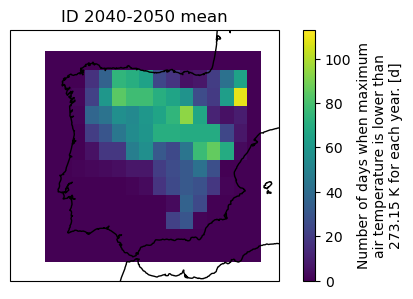

In [65]:
iced = icclim.index(
    index_name="ID",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmin_debiased",
)

iced_min = float(iced['ID'].min().values)
iced_max = float(iced['ID'].max().values)

visualise_index(iced, 'ID', "ID 2040-2050 mean", cmin = iced_min, cmax = iced_max)

## R10mm
**Description:** Heavy precipitation days

**Application:** Provides information on crop damage
and runoff losses

2025-03-26 17:36:18,498 --- icclim 7.0.0
2025-03-26 17:36:18,498 --- BEGIN EXECUTION
2025-03-26 17:36:18,498 Processing: 0%
2025-03-26 17:36:18,538 Processing: 100%
2025-03-26 17:36:18,538 --- icclim 7.0.0
2025-03-26 17:36:18,540 --- CPU SECS = 45.781    
2025-03-26 17:36:18,540 --- END EXECUTION


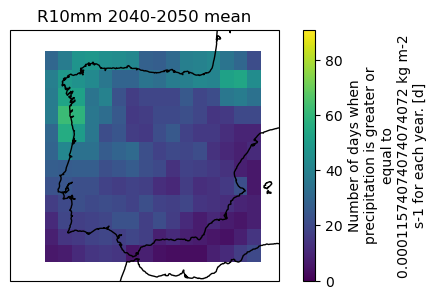

In [66]:
r10mm = icclim.index(
    index_name="R10mm",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="pr_debiased",
)

r10mm_min = float(r10mm['R10mm'].min().values)
r10mm_max = float(r10mm['R10mm'].max().values)

visualise_index(r10mm, 'R10mm', "R10mm 2040-2050 mean", cmin = r10mm_min, cmax = r10mm_max)

## R20mm
**Description:** Very heavy precipitation days

**Application:** Provides information on crop damage
and runoff losses

2025-03-26 17:36:25,276 --- icclim 7.0.0
2025-03-26 17:36:25,276 --- BEGIN EXECUTION
2025-03-26 17:36:25,284 Processing: 0%
2025-03-26 17:36:25,329 Processing: 100%
2025-03-26 17:36:25,331 --- icclim 7.0.0
2025-03-26 17:36:25,332 --- CPU SECS = 46.062    
2025-03-26 17:36:25,332 --- END EXECUTION


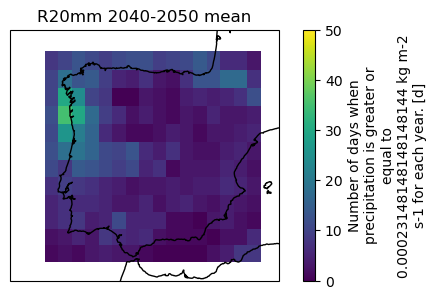

In [67]:
r20mm = icclim.index(
    index_name="R20mm",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="pr_debiased",
)

r20mm_min = float(r20mm['R20mm'].min().values)
r20mm_max = float(r20mm['R20mm'].max().values)

visualise_index(r20mm, 'R20mm', "R20mm 2040-2050 mean", cmin = r20mm_min, cmax = r20mm_max)

## RR
**Description:** Precipitation sum

**Application:** Provides information on possible water
shortage or excess.

2025-03-26 17:36:30,702 --- icclim 7.0.0
2025-03-26 17:36:30,702 --- BEGIN EXECUTION
2025-03-26 17:36:30,702 Processing: 0%
2025-03-26 17:36:30,747 Processing: 100%
2025-03-26 17:36:30,747 --- icclim 7.0.0
2025-03-26 17:36:30,747 --- CPU SECS = 46.281    
2025-03-26 17:36:30,747 --- END EXECUTION


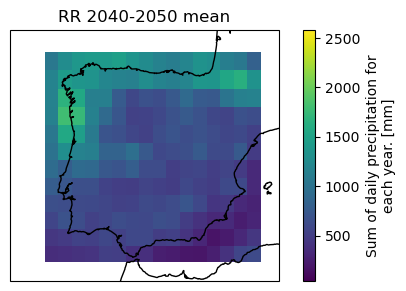

In [68]:
rr = icclim.index(
    index_name="RR",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="pr_debiased",
)

rr_min = float(rr['RR'].min().values)
rr_max = float(rr['RR'].max().values)

visualise_index(rr, 'RR', "RR 2040-2050 mean", cmin = rr_min, cmax = rr_max)

## RR1
**Description:** Wet Days

**Application:** Provides information on intercepted
reduction

2025-03-26 17:36:37,634 --- icclim 7.0.0
2025-03-26 17:36:37,640 --- BEGIN EXECUTION
2025-03-26 17:36:37,640 Processing: 0%
2025-03-26 17:36:37,682 Processing: 100%
2025-03-26 17:36:37,682 --- icclim 7.0.0
2025-03-26 17:36:37,682 --- CPU SECS = 46.562    
2025-03-26 17:36:37,682 --- END EXECUTION


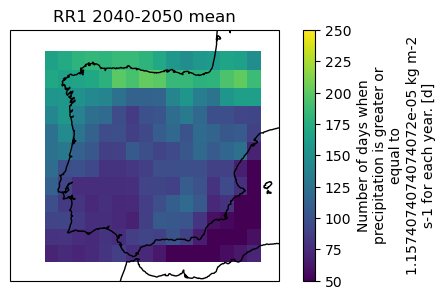

In [69]:
rr1 = icclim.index(
    index_name="RR1",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="pr_debiased",
)

rr1_min = float(rr1['RR1'].min().values)
rr1_max = float(rr1['RR1'].max().values)

visualise_index(rr1, 'RR1', "RR1 2040-2050 mean", mask_values=[366,0], cmin = 50, cmax = 250)

## SDII
**Description:** Simple daily intensity index

**Application:** Provides information on possible run off
losses.

2025-03-26 17:36:44,492 --- icclim 7.0.0
2025-03-26 17:36:44,492 --- BEGIN EXECUTION
2025-03-26 17:36:44,492 Processing: 0%
2025-03-26 17:36:44,523 Processing: 100%
2025-03-26 17:36:44,523 --- icclim 7.0.0
2025-03-26 17:36:44,523 --- CPU SECS = 46.766    
2025-03-26 17:36:44,523 --- END EXECUTION


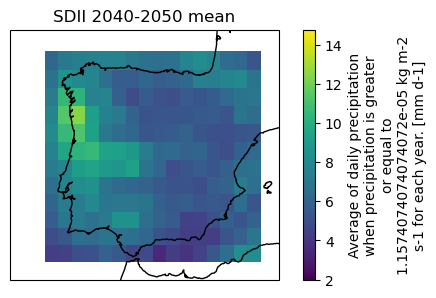

In [70]:
sdii = icclim.index(
    index_name="SDII",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="pr_debiased",
)

sdii_min = float(sdii['SDII'].min().values)
sdii_max = float(sdii['SDII'].max().values)

visualise_index(sdii, 'SDII', "SDII 2040-2050 mean", cmin = sdii_min, cmax = sdii_max)

## SU
**Description:** Summer days

**Application:** Provide an indication concerning the occurrence of heat stress. Also base for crop specific variants for heat/cold stress (above/below the crop specific
optimal temperature thresholds)

2025-03-26 17:36:51,749 --- icclim 7.0.0
2025-03-26 17:36:51,749 --- BEGIN EXECUTION
2025-03-26 17:36:51,749 Processing: 0%
2025-03-26 17:36:51,796 Processing: 100%
2025-03-26 17:36:51,796 --- icclim 7.0.0
2025-03-26 17:36:51,796 --- CPU SECS = 46.969    
2025-03-26 17:36:51,796 --- END EXECUTION


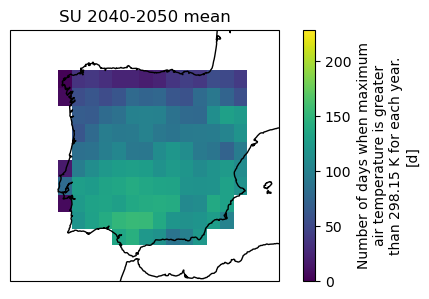

In [71]:
su = icclim.index(
    index_name="SU",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmax_debiased",
)

su_min = float(su['SU'].min().values)
su_max = float(su['SU'].max().values)

visualise_index(su, 'SU', "SU 2040-2050 mean", mask_values=[366,0], cmin = su_min, cmax = su_max)

## TG
**Description:** Mean of daily mean temperature

**Application:** Provides information on long-term
climate variability and change

2025-03-26 17:36:58,600 --- icclim 7.0.0
2025-03-26 17:36:58,609 --- BEGIN EXECUTION
2025-03-26 17:36:58,609 Processing: 0%
2025-03-26 17:36:58,647 Processing: 100%
2025-03-26 17:36:58,647 --- icclim 7.0.0
2025-03-26 17:36:58,647 --- CPU SECS = 47.188    
2025-03-26 17:36:58,647 --- END EXECUTION


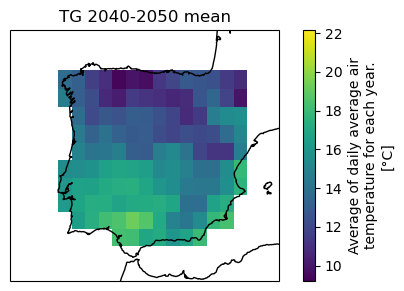

In [72]:
tg = icclim.index(
    index_name="TG",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tas_debiased",
)

tg_min = float(tg['TG'].min().values)
tg_max = float(tg['TG'].max().values)

visualise_index(tg, 'TG', "TG 2040-2050 mean", cmin = tg_min, cmax = tg_max)

## TN
**Description:** Mean of daily minimum temperature

**Application:** Provides information on long-term
climate variability and change

2025-03-26 17:37:05,113 --- icclim 7.0.0
2025-03-26 17:37:05,129 --- BEGIN EXECUTION
2025-03-26 17:37:05,129 Processing: 0%
2025-03-26 17:37:05,147 Processing: 100%
2025-03-26 17:37:05,147 --- icclim 7.0.0
2025-03-26 17:37:05,147 --- CPU SECS = 47.422    
2025-03-26 17:37:05,147 --- END EXECUTION


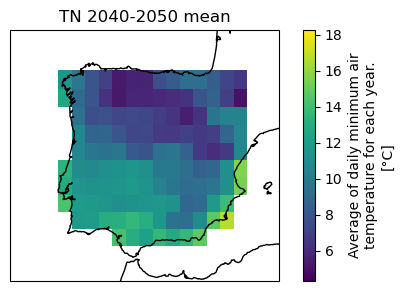

In [73]:
tn = icclim.index(
    index_name="TN",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmin_debiased",
)

tn_min = float(tn['TN'].min().values)
tn_max = float(tn['TN'].max().values)

visualise_index(tn, 'TN', "TN 2040-2050 mean", cmin = tn_min, cmax = tn_max)

## TNn
**Description:** Minimum value of the daily minimum
Temperature

**Application:** Provides information on long-term
climate variability and change

2025-03-26 17:37:12,172 --- icclim 7.0.0
2025-03-26 17:37:12,172 --- BEGIN EXECUTION
2025-03-26 17:37:12,172 Processing: 0%
2025-03-26 17:37:12,207 Processing: 100%
2025-03-26 17:37:12,207 --- icclim 7.0.0
2025-03-26 17:37:12,207 --- CPU SECS = 47.656    
2025-03-26 17:37:12,207 --- END EXECUTION


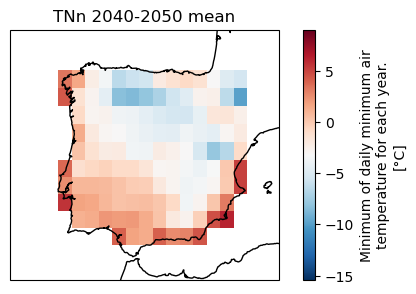

In [74]:
tnn = icclim.index(
    index_name="TNn",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmin_debiased",
)

tnn_min = float(tnn['TNn'].min().values)
tnn_max = float(tnn['TNn'].max().values)

visualise_index(tnn, 'TNn', "TNn 2040-2050 mean", cmin = tnn_min, cmax = tnn_max)

## TNx
**Description:** Maximum value of the daily
minimum temperature

**Application:** Provides information on long-term
climate variability and change

2025-03-26 17:37:19,252 --- icclim 7.0.0
2025-03-26 17:37:19,252 --- BEGIN EXECUTION
2025-03-26 17:37:19,252 Processing: 0%
2025-03-26 17:37:19,280 Processing: 100%
2025-03-26 17:37:19,280 --- icclim 7.0.0
2025-03-26 17:37:19,280 --- CPU SECS = 47.859    
2025-03-26 17:37:19,282 --- END EXECUTION


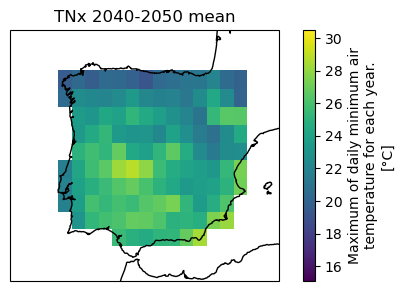

In [75]:
tnx = icclim.index(
    index_name="TNx",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmin_debiased",
)

tnx_min = float(tnx['TNx'].min().values)
tnx_max = float(tnx['TNx'].max().values)

visualise_index(tnx, 'TNx', "TNx 2040-2050 mean", cmin = tnx_min, cmax = tnx_max)

## TR
**Description:** Tropical nights

**Application:** Provide an indication of occurrence of various pests.

2025-03-26 17:37:25,188 --- icclim 7.0.0
2025-03-26 17:37:25,188 --- BEGIN EXECUTION
2025-03-26 17:37:25,188 Processing: 0%
2025-03-26 17:37:25,225 Processing: 100%
2025-03-26 17:37:25,225 --- icclim 7.0.0
2025-03-26 17:37:25,225 --- CPU SECS = 48.062    
2025-03-26 17:37:25,225 --- END EXECUTION


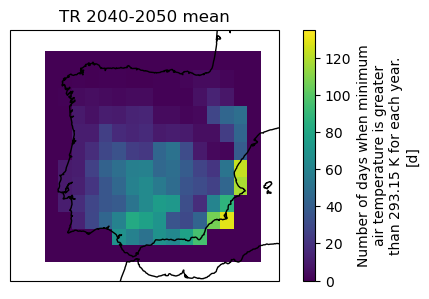

In [76]:
tr = icclim.index(
    index_name="TR",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmin_debiased",
)

tr_min = float(tr['TR'].min().values)
tr_max = float(tr['TR'].max().values)

visualise_index(tr, 'TR', "TR 2040-2050 mean", cmin = tr_min, cmax = tr_max)

## TX
**Description:** Mean of daily maximum temperature

**Application:** Provides information on long-term
climate variability and change

2025-03-26 17:37:31,072 --- icclim 7.0.0
2025-03-26 17:37:31,072 --- BEGIN EXECUTION
2025-03-26 17:37:31,072 Processing: 0%
2025-03-26 17:37:31,110 Processing: 100%
2025-03-26 17:37:31,110 --- icclim 7.0.0
2025-03-26 17:37:31,110 --- CPU SECS = 48.297    
2025-03-26 17:37:31,110 --- END EXECUTION


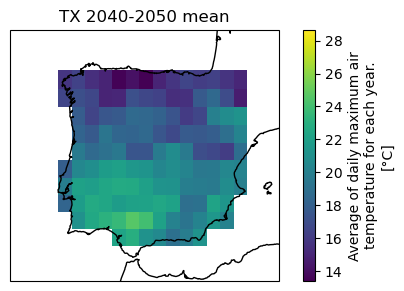

In [77]:
tx = icclim.index(
    index_name="TX",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmax_debiased",
)

tx_min = float(tx['TX'].min().values)
tx_max = float(tx['TX'].max().values)

visualise_index(tx, 'TX', "TX 2040-2050 mean", cmin = tx_min, cmax = tx_max)

## TXn
**Description:** Minimum value of daily maximum
temperature

**Application:** Provides information on long-term
climate variability and change

2025-03-26 17:37:38,161 --- icclim 7.0.0
2025-03-26 17:37:38,161 --- BEGIN EXECUTION
2025-03-26 17:37:38,161 Processing: 0%
2025-03-26 17:37:38,215 Processing: 100%
2025-03-26 17:37:38,218 --- icclim 7.0.0
2025-03-26 17:37:38,218 --- CPU SECS = 48.562    
2025-03-26 17:37:38,218 --- END EXECUTION


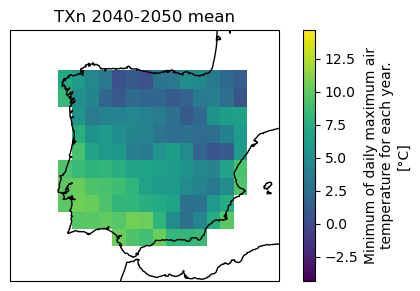

In [78]:
txn = icclim.index(
    index_name="TXn",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmax_debiased",
)

txn_min = float(txn['TXn'].min().values)
txn_max = float(txn['TXn'].max().values)

visualise_index(txn, 'TXn', "TXn 2040-2050 mean", cmin = txn_min, cmax = txn_max)

## TXx
**Description:** Maximum value of daily maximum
temperature

**Application:** Provides information on long-term
climate variability and change


2025-03-26 17:37:44,690 --- icclim 7.0.0
2025-03-26 17:37:44,690 --- BEGIN EXECUTION
2025-03-26 17:37:44,690 Processing: 0%
2025-03-26 17:37:44,721 Processing: 100%
2025-03-26 17:37:44,721 --- icclim 7.0.0
2025-03-26 17:37:44,721 --- CPU SECS = 48.766    
2025-03-26 17:37:44,735 --- END EXECUTION


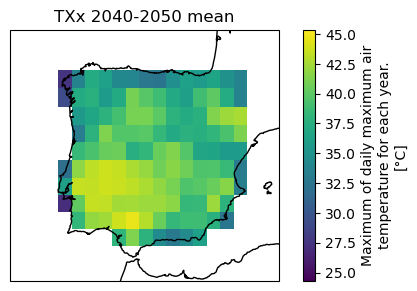

In [79]:
txx = icclim.index(
    index_name="TXx",
    in_files=f"{combined_future_debiased_path.resolve()}",
    var_name="tasmax_debiased",
)

txx_min = float(txx['TXx'].min().values)
txx_max = float(txx['TXx'].max().values)

visualise_index(txx, 'TXx', "TXx 2040-2050 mean", cmin = txx_min, cmax = txx_max)